Notebook by **Jakob R. Jürgens** - Final project for the course **Computational Statistics** in the summer semester 2021 - Find me at [jakobjuergens.com](https://jakobjuergens.com) <br>
# Comparison of Variable Importance Feature Selection Methods in Continuous Response Random Forest
---

## Introduction <a name="introduction"></a>
---
When using tree based methods such as random forests there are typically two appraoches. In the vocabulary of *Hapfelmeier and Ulm (2013)* which will be an important part of this project:
1. "**Performance-based**" approaches that try to achieve the best prediction accuracy without meaningful interest in interpreting the results of the procedure beyond its predictive capabilities
2. "**Test-based**" approaches typically used to identify variables with predictive qualities for a response variable with the intention of building a model on top of this information

This project will compare methods that are supposed to fulfill the second purpose and show the differences in their choice of variables that are supposedly informative on a continuous response variable.


* Feature selection using random forests and permutation tests
* To address problems of bias towards continuous features or features with many levels
* Bias towards correlated variables, different importance measures

## Table of Contents <a name="tableofcontents"></a>
---
1. [Introduction](#introduction)
2. [Table of Contents](#tableofcontents)
3. [Preliminary Steps](#preliminaries)
4. [Theory Prerequisites](#Theory)
    1. [Classification and Regression Trees](#CART)
    1. [Random Forests](#RF)
    1. [Feature Selection and Importance Measures](#FS_IM)
    1. [Selection Biases](#selbias)
    1. [Conditional Variable Importance for Random Forests](#CVI)
    1. [Conditional Inference Trees](#CIT)
    1. [Conditional Inference Random Forests](#CIRF)
    1. [Permutation Approach by Hapfelmeier and Ulm](#hpflmr_ulm)
5. [Implementations](#implementation)
    1. [package randomForest](#pckg_rf)
    1. [package party & partykit](#pckg_party)
6. [Functions for Simulation](#functions)
7. [Simulation Study](#simulation)
8. [Application](#application)
9. [Conclusion](#conclusion)
10. [Outlook and possible Extensions](#outlook)
11. [Bibliography](#bibliography)

## Preliminary Steps <a name="preliminaries"></a>
---

In the following, blocks of word for word quotes are marked by indentations as the following example illustrates:
> EXAMPLE

Package Installations if necessary:

In [26]:
#install.packages("qut")
#install.packages("randomForest")
#install.packages("party")
#install.packages("partykit")
#install.packages("parallel")
#install.packages("MASS")
#install.packages("tidyverse")
#install.packages("repr")
#install.packages("patchwork")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


Load packages:

In [27]:
suppressMessages(library(qut)) # for data set "riboflavin"
suppressMessages(library(randomForest)) # for normal random forests
suppressMessages(library(party)) # to allow for conditional inference trees
suppressMessages(library(partykit)) # to allow for conditional inference random forests
suppressMessages(library(parallel)) # for parallelisation of the simulations
suppressMessages(library(MASS)) # for multivariate normal distributions
suppressMessages(library(tidyverse)) # for general programming (mostly purrr & ggplot used)
suppressMessages(library(repr)) # for changing plot sizes
suppressMessages(library(patchwork)) # for combining plots

options(repr.plot.width=30, repr.plot.height=8)

Load Data set for application part:

In [8]:
data(riboflavin)

Import from Auxiliary files:

In [7]:
source("Visualizations.R")

## Theory Prerequisites<a name="theory"></a>
---
Before going into the details of the simualtion study conducted in this project, I first inftroduce some theoretical concepts that are necessary to get an informed understanding of the simulation procedures and to interpret the results of said simulations. As the focus of the simulation will lie on different variable importance based feature seclection methods, I will introduce a selection of increasingly complex methods that in turn try to address biases of proviously developped methods. Since most of these methods are either not based on hypothesis testing (**CART**) or test for the violation of slightly different hypotheses, it will be important to spell out the methods and hypotheses in detail to allow for interpretation of the results in a later part of this project. <br>

Additionally I give references to papers that lay the theoretical foundation of these concepts or prove the stated features of the statistical objects as a thorough presentation of the theoretical background of especially the methods based on a framework of permutation tests is out of the scope of this project. This is also meant to serve as a historical motivation for the simulation study as the methods presented follow an evolution of tree based methods to address a specific class of problems found over time.

### Classification and Regression Trees <a name="CART"></a>
---
I take the Classification and Regression Tree Algorithm (**CART**) introduced by *Breiman, Friedman, Olshen, and Stone (1984)* as a baseline for the points made in the next paragraphs. So when a bias in the original procedure is addressed, this is to be taken as a statement relating to **CART** and Random Forests built on top of it. Therefore, I am introducing this algorithm first to make the differences clearer when talking about later approaches. I am limiting my description to the regression case of **CART** as regression problems in distinction to classification problems will be the focus of this project. For my presentation of the algorithm I am following Chapter 8 in *James, Witten, Hastie, and Tibshirani (2013)* in my description of the algorithm. <br>
The authors split up the process of building a regression tree into the following two steps (quoting from the book)

> 1. <em> We divide the predictor space [$X$] — that is, the set of possible values for X<sub>1</sub> , X<sub>2</sub> , . . . , X<sub>p</sub> — into J distinct and non-overlapping regions, R<sub>1</sub> , R<sub>2</sub> , . . . , R<sub>J</sub>. </em>
> 2. <em> For every observation that falls into the region R<sub>j</sub>, we make the same prediction, which is simply the mean of the response values for the training observations in R<sub>j</sub>. </em>

and elaborate on  both steps in more detail after. <br>
Relating to the creating of the distinct non-overlapping regions mentioned in step one choices have to be made in multiple dimensions:
* What types of regions are to be considered? 
* In what sense should a set of regions be optimal i.e. what criterion is used to evaluate a sets performance?
* Shall there be a stopping criterion, that prohibits further splitting, even if it would improve the tree's performance according to the chosen criterion?
* What method shall be used to find the optimal set?

Typical choices for these points are the following:
* Only consider regions that are p-dimensional rectangles. This allows for splits to be decided according to the value of one covariate at each node. <br>
Other possibilities could be linear combinations of covariates leading to a different tree concept for example.
* The criterion to evaluate a set's performance can be chosen quite freely, but a typical choice is the sum of squared residuals (**RSS**).

\begin{equation}
    \text{RSS} = \sum_{j=1}^J \sum_{i \in R_j} (y_i - \hat{y}_{R_j})^2
\end{equation}

* A typical choice for a stopping criterion is a minimal number of observations in a region. Even if an optimal split would decrease **RSS** for the overall tree, the split is not performed as to not fall under this threshold.
* In a setting with a finite amount of observations, it is theoretically possible to evaluate all possible splits (up to identical fitted values) corresponding to regions as described above. <br>
This, however, is computationally infeasible. Therefore, an approach called **Recursive Binary Splitting** is taken that follows a greedy, top-down structure.

Again quoting from *James, Witten, Hastie, and Tibshirani (2013)*: <br>
> <em> The approach is top-down because it begins at the top of the tree [...] and then successively splits the predictor space; each split is indicated via two new branches further down on the tree. </em> <br>
> <em> It is greedy because at each step of the tree-building process, the best split is made at that particular step, rather than looking ahead and picking a split that will lead to a better tree in some future step. </em> 

At each step of the tree building process, splits are constructed according to a criterion that evaluates their performance. <br>
Assume that **RSS** was chosen as a criterion and that at a node $N_k$ currently represents a p-dimensional rectangle $R_k$. We then construct the next split at this node by minimizing the **RSS** of the full tree over all possible splits at this node. This is equivalent to minimizing the **RSS** on $R_i$ by splitting up $R_k$ into two disjoint p-dimensional rectangles in some in some dimension $j \in \{1, \dots, p\}$ at a threshold value $s$. In mathematical terms, slightly modifying the definitions from *James, Witten, Hastie, and Tibshirani (2013)*, let 

\begin{equation}
R_{k,1}(j,s) = R_k \cap \{X | X_j < s\} \quad \text{and} \quad R_{k,2}(j,s) = R_k \cap \{X | X_j \geq s\}
\end{equation}

and choose $j$ and $s$ to minimize

\begin{equation}
\sum_{i: x_{i} \in R_{k,1}(j, s)}\left(y_{i}-\hat{y}_{R_{k,1}}\right)^{2}+\sum_{i: x_{i} \in R_{k,2}(j, s)}\left(y_{i}-\hat{y}_{R_{k,2}}\right)^{2}
\end{equation}

where $\hat{y}_{R_{k,1}}$ and $\hat{y}_{R_{k,2}}$ are the means of the dependent variable of the observations in the resulting rectangles. <br>

A tree is constructed by recursively applying this procedure to nodes until no further splits can be made without violating the stopping condition (or until no more splits can be made that improve the **RSS**). <br>
Given a tree, prediction of the dependent variable given observed covariates is done by checking which p-dimensional rectangle a new observation falls into and using the assigned value of this rectangle. <br>

As can be seen in this description of the building process there is no significance testing and no formulation of a hypothesis in creating splits or in the stopping condition. This can be problematic for interpretability, but as regression trees and later random forests are often treated as black boxes in the sense that their splits are not to be interpreted in a real world sense, but used more for their properties in prediction accuracy the underlying simplicity of this procedure might be more desirable than more advanced methods presented in later sections that allow for more statistical insight in their interpretation.
    

### Random Forests <a name="RF"></a>
---
Building up on this rather simple way to construct a tree, there are multiple ways to improve predictive performance among other properties by combining multiple trees. One such method introduced by *Ho (1995)* and extended by *Breiman (2001)* is Random Forest. <br>
In contrast to Boosting which uses a combination of weak learners to improve its bias, Random Forest is based on the averaging of strong learners to decrease variance. Analoguous to a simple scalar case concerning for example the estimation of the population mean from a sample, the decrease in variance via averaging depends on the correlation between the data points. In case of Random Forests this relates to the correlation between the predictions of each individual tree. 

The idea is to construct multiple trees, often deliberately overfitting the data, and to average their results to obtain an overall prediction of the forest. This can for example be used to improve prediction quality but also to improve the procedures qualities for feature selection. <br>To decorrelate the trees, Random Forest deploys two important variations on the original regression tree idea.
* Like in bagging each tree is constructed on a bootstrapped sample of the original data. 
* At each split in a tree, only a subset of dimensions is considered during its creation. A typical choice in the case of p covariates is to randomly choose $m \approx \sqrt{p}$ covariates that are considered for the new split. <br>
(m = p corresponds to bagging)

Mathematically speaking, the construction of each tree happens as follows:
1. Construct a bootstrap sample $B_l = \{b_1^l, \dots, b_w^l\}$ of size w from the original data set. <br>
(This can also be varied to build trees on subsamples without replacement. For the sake of simplicity, I focus on the bootstrapping approach and later elaborate on cases where subsampling without replacement is used instead.)
2. Construct a tree on $B_l$ instead of the original data set as described in the previous section with the following modification:

Assume again, that a node $N_k^l$ represents a p-dimensional rectangle $R_k^l$ and that a new split is to be implemented at $N_k^l$. For the sake of simplicity assume that the chosen stopping condition is not violated. <br>
Let $M_k^l \subseteq \{1, \dots, p\}$ with $|M_k^l| = m$ for some $m \in \mathcal{N}$. <br>

As previously defined, let

\begin{equation}
R_{k,1}^l(j,s) = R_k^l \cap \{X | X_j < s\} \quad \text{and} \quad R_{k,2}^l(j,s) = R_k^l \cap \{X | X_j \geq s\}
\end{equation}

be the p-dimensional rectangles created by a new split in dimension $j$ at threshold $s$. <br>
Now choose $j \in M_i^l$ and $s$ to minimize

\begin{equation}
\sum_{i: x_{i} \in R_{k,1}^l(j, s)}\left(y_{i}-\hat{y}_{R_{k,1}^l}\right)^{2}+\sum_{i: x_{i} \in R_{k,2}^l(j, s)}\left(y_{i}-\hat{y}_{R_{k,2}^l}\right)^{2}
\end{equation}

where $\hat{y}_{R_{k,1}^l}$ and $\hat{y}_{R_{k,2}^l}$ are the means of the dependent variable of the bootstrap observations in the resulting rectangles. <br>

Aggregation of results can happen in a multitude of ways: typical choices in the case of prediction are mean or median of the predicted values from the constructed trees.

### Feature Selection and Importance Measures <a name="FS_IM"></a>
---

As this project is mostly concerned with the selection of features with predictive qualities for the dependent variable over raw predictive performance of the overall model, it is important to elaborate on the procedures used to determine a covariate's importance in this regard. Depending of the context the notion of importance for the prediction of a dependent variable can be different. Two reasonable concepts of variable importance employed in different real world scenarios are the following:

1. Variables that are informative for the value of the dependent variable themselves or correlated to informative variables should have high variable importance.
2. Only variables that are informative for the dependent variable themselves should have high variable importance.

As the focus of this project lies on cases with continuous response variables, the importance measures used in the case of regression trees and random forests derived from them are of bigger importance in this context. However, similar measures based on the Gini impurity or Shannon entropy are available for classification problems and much of the following theory carries over. Nevertheless, focus will lie on the case of continuous response variables in the following. In general the question of the predictive quality of a covariate $X_j$ for a response variable $Y$ in the first sense shown above is typically associated with an orthogonality hypothesis as follows:

\begin{equation}
H_0: Y \perp X_j
\end{equation}

However, typical independence measures used in the literature often either check a slightly different hypothesis or only rank possible predictors according to an importance criterion without making statements on the hypothesis above. Additionally slightly more advanced hypotheses actually referring to independence not only orthogonality are used if the second notion of informative covariates is used. In the following I will therefore give an overview over some typical and more advanced variable importance criteria to compare them in a simulation study.

#### Variance Reduction

A typical importance measure for covariates in regression trees is the sum of reduction in **RSS** that is achieved at notes corresponding to a specific covariate. Recall the explanation of the splitting procedure in regression trees given a few paragraphs above. As the defining factor for the choice of dimension and threshold was the resulting reduction in **RSS**, it seems reasonable to evaluate the importance of a covariate by looking at the reduction in **RSS** in the whole tree attributable to splits in the corresponding dimension. <br>
Let $N^j(T)$ be the set of nodes of tree $T$ that implement splits in $X_j$. At each of these nodes there is a corresponding value of **RSS** pre-splitting and post-splitting. Call these values $\textbf{RSS}_{pre}(N)$ and $\textbf{RSS}_{post}(N)$ for a generic node $N \in N^j(T)$. A typical importance measure for the case of the regression variant of **CART** is then given by:

\begin{equation}
\textbf{VIM}_{RSS}(T, X_j) = \sum_{N \in N^j(T)}\big[ \textbf{RSS}_{pre}(N) - \textbf{RSS}_{post}(N) \big]
\end{equation}

For the case of Random Forests, one idea is to carry over this metric and enter consideration via averaging over all trees of the forest. <br>
Assuming that $L$ trees $T_{B_1}, \dots, T_{B_L}$ were constructed based on bootstrap samples $B_1, \dots, B_L$ as described in the section on random forests, an overall importance measure of covariate $X_j$ could then be implemented as

\begin{equation}
\textbf{VIM}_{RF}(X_j) = \frac{1}{L} \sum_{l = 1}^L \textbf{VIM}_{RSS}(T_{B_l}, X_j).
\end{equation}

This is a rather intuitive criterion. However, it has some flaws and can be improved in some regards using a little more sophistication. As this method will not be in the focus of the later simulations, I limit the extent of this presentation to a short list of ideas as an appropriate discussion is out of the scope of this project. These points can serve as a starting grounds for further literature review for an interested reader.

* Instead of using the bootstrapped training data to evaluate the importance of a feature, it is possible and in some cases advisable to base the importance measure on the out of bag (**OOB**) observations that are not part of the bootstrap sample.
* The squared sum of residuals is not necessarily optimal in this regard. Prediction accuracy on the **OOB** observations is another reasonable choice.
* Weighted averages or the median could be employed instead of the unweighted mean.

This importance measure belongs to the category of measures that only rank predictors according to a criterion without an underlying hypothesis of orthogonality or independence. This however must not be a disadvantage in some scenarios, when interpretation of a model is not of utmost importance and achieving high predictive accuracy with a limited set of predictors is the goal.

#### Permutation Accuracy Importance in Random Forests

There is also a different kind of importance measure derived from random forests based on a framework of permutation. These methods, though a little more complex than those based on averaging, gained popularity and are more typical in applied work using random forests for feature selection. In my presentation of the basic permutation based importance measures for Random Forest, I am going to follow *Strobl, Boulesteix, Zeileis, and Hothorn (2007)*. The authors give the following rationale for this class of importance measures

> By randomly permuting the predictor variable X<sub>j</sub>, its original association with the response Y is broken. When the permuted variable X<sub>j</sub>, together with the remaining unpermuted predictor variables, is used to predict the response, the prediction accuracy [...] decreases substantially, if the original variable X<sub>j</sub> was associated with the response. Thus, a reasonable measure for variable importance is the difference in prediction accuracy before and after permuting X<sub>j</sub>.

The example made in the paper relates to a classification problem, where prediction accuracy can be identified by the share of correctly classified observations. In a later paper (*Strobl, Boulesteix, Kneib, Augustin, and Zeiles (2008)*) the authors give the following formula for the case of a classification random forest, which can easily be adjusted to define a similar measure for regression random forests. The following formula describes the importance measure derived for a single tree:

\begin{equation}
    \textbf{VI}^{(t)}\left(\mathbf{X}_{j}\right)=\frac{\sum_{i \in {\overline{\mathcal{B}}}^{(t)}} I\left(y_{i}=y_{i}^{(t)}\right)}{|\overline{\mathcal{B}}^{(t)}|}-\frac{\sum_{i \in {\overline{\mathcal{B}}}^{(t)}} I\left(y_{i}=y_{i, \pi_{j}}^{(t)}\right)}{|\overline{\mathcal{B}}^{(t)}|}
\end{equation}

where 
* $\overline{\mathcal{B}}^{(t)}$ is the out of bag (**OOB**) sample for a tree $t$ of the forest
* $y_{i}$ is the class of an observation
* $y_{i}^{(t)}$ is the class assigned to an observation by tree $t$
* $y_{i, \pi_{j}}^{(t)}$ is the class assigned to an observation with permuted dimension $X_j$ by tree $t$

Again, this criterion depends on an aggregation over all trees in the forest, for which the authors suggest an unweighted mean over the importance measures given by the individual trees.

\begin{equation}
\textbf{VI}\left(\mathbf{X}_{j}\right) = \frac{\sum_{t=1}^{\text{ntree}}{\textbf{VI}^{(t)}}\left(\mathbf{X}_{j}\right)}{\text{ntree}}
\end{equation}

Adjusting these measures to work for continuous response variables leads to something akin to the following formulas:

\begin{equation}
    \textbf{VI}^{(t)}\left(\mathbf{X}_{j}\right)=\frac{\sum_{i \in {\overline{\mathcal{B}}}^{(t)}} \left(y_{i} - y_{i, \pi_{j}}^{(t)}\right)^2}{|\overline{\mathcal{B}}^{(t)}|} - \frac{\sum_{i \in {\overline{\mathcal{B}}}^{(t)}} \left(y_{i} - y_{i}^{(t)}\right)^2}{|\overline{\mathcal{B}}^{(t)}|}
\end{equation}

where 
* $\overline{\mathcal{B}}^{(t)}$ is the out of bag (**OOB**) sample for a tree $t$ of the forest
* $y_{i}$ is the response variable of an observation
* $y_{i}^{(t)}$ is the predicted response variable assigned to an observation by tree $t$
* $y_{i, \pi_{j}}^{(t)}$ is the predicted response variable assigned to an observation with permuted dimension $X_j$ by tree $t$

and aggregation is again done via averaging.

In the same paper (*Strobl et al.(2008)*) the authors relate this approach to a slightly different hypothesis then the independence of $X_j$ and $Y$ presented in the beginng. The authors argue that this simple permutation approach instead also incorporates the covariates $Z = X_1, \dots, X_{j-1}, X_{j+1}, \dots, X_p$ that $X_j$ is permuted relative to in addition to $Y$. Therefore the implied hypothesis of this approach is instead the following:

\begin{equation}
H_0: X_j \perp Y, Z
\end{equation}

This leads to the possibility that a change in the correlation structure due to the premutation can influence a possible test statistic in the direction of discarding the hypothesis. This, however, is typically not a desired property of a feature selection method which led to the devellopment of their conditional importance measures presented in a later paragraph, that tries to remedy this problem.

It is important to see that contrary to the importance measures in a single non-random tree the importance measures in a random forest are inherently stochastic. Not only due to the random nature of the trees themselves but also due to the randomness of the permutations used to calcualte a permutation variable importance. Therefore it is important to not use a small number of trees in a random forest for variable selection and in some cases it is even advisable to do multiple permutations per tree for the calculation of permutation based importance measures. The latter part, however, is often overgone in favor of increasing the number of trees, which provide sufficient accuracy of the importance measure. <br>

#### Remarks
When looking at the previously made categorization, both of these measures fall into category 1. and cannot easily be used to separate intrinsically informative variables from those that are only correlated to directly informative variables. 


### Selection Biases <a name="selbias"></a>
---
The methods for feature selection described in the previous section have been employed successfully in a plethora of applications. However, theoretical analyses have shown, that there are systematic biases towards specific types of variables exhibited by these methods. *Strobl, Boulesteix, Zeileis, and Hothorn (2007)* summarise previous findings on variable selection biases in random forests due to biases present in the individual trees (*Kononenko (1995)*, *Dobra and Gehrke (2001)*, and others) and extend the attention to biases present due to bootstrapping in the construction of the forest. The authors conduct a simulation study to compare different random forest based importance measures and to study their inherent biases when confronted with data of different structure.

<span style="color:red"> HIER WEITERSCHREIBEN!!! </span>.

Important findings summarised and supported by the simulaton study are the following:
* 

In *Strobl, Boulesteix, Kneib, Augustin, and Zeileis (2008)* the authors additionally go into further detail on biases towards correlated predictor variables and develop a conditional permutation scheme to improve the computed variable importance measures to combat these biases. This is especially interesting when using the second notion of variable importance mentioned above, meaning that variables that are not intrinsically informative on the response variable but only correlated with at least one such variable are not to be considered relevant. To do so they introduce a modified permutation scheme to base an importance measure on which is explained in the next section.

### Conditional Variable Importance for Random Forests <a name="CVI"></a>
---

As mentioned in the previous subsection, *Strobl, Boulesteix, Kneib, Augustin, and Zeiles (2008)* identify additional biases and develop a new approach to compute unbiased variable importance measures. These belong to a new class called conditional variable importance measures and are based on permutation in the same sense as previously described methods. However, to improve on certain properties permutation only takes place within specified subsets of the data used to create the tree.

The bias identified by the authors comes into effect when multiple covariates are correlated and it becomes important to distinguish between the marginal effect of an increase in one dimension and the conditional influence in relation to a set of conditioning variables. The authors describe that in a setting like random forest based on **CART** variable importance measures will not be able to effectively distinguish truly influential predictor variables from those that are only correlated with influential predictors and perform a simulaton study to illustrate this point. The theoretical intuition given for this phenomenon is provided in form of an analogy to permutation tests, where a typical (unconditional) permutation approach as described before relates to a different hypothesis that can be violated by a change in the test statistic not attributable to a change in the relation to the response variable but in the correlation structure of the observables as presented in the section of the simple permutation approach. <br>
As this is often not the intended outcome in feature selection the authors present a rationale to limit permutations of individual covariates to regions of predictor spaced defined by the tree's structure as to adequately address conditioning on other predictors in feature selection. <br>
The authors also extend this structure to cases where the conditioning variables can be chosen manually but describe the typical case of conditioning induced by the tree structure in the following sense (for the sake of simplicity visualizations are done with two predictor variables):

Imagine that a tree came up with the following partitioning of a two dimensional predictor space and the derived regions for permutation of a covariate:

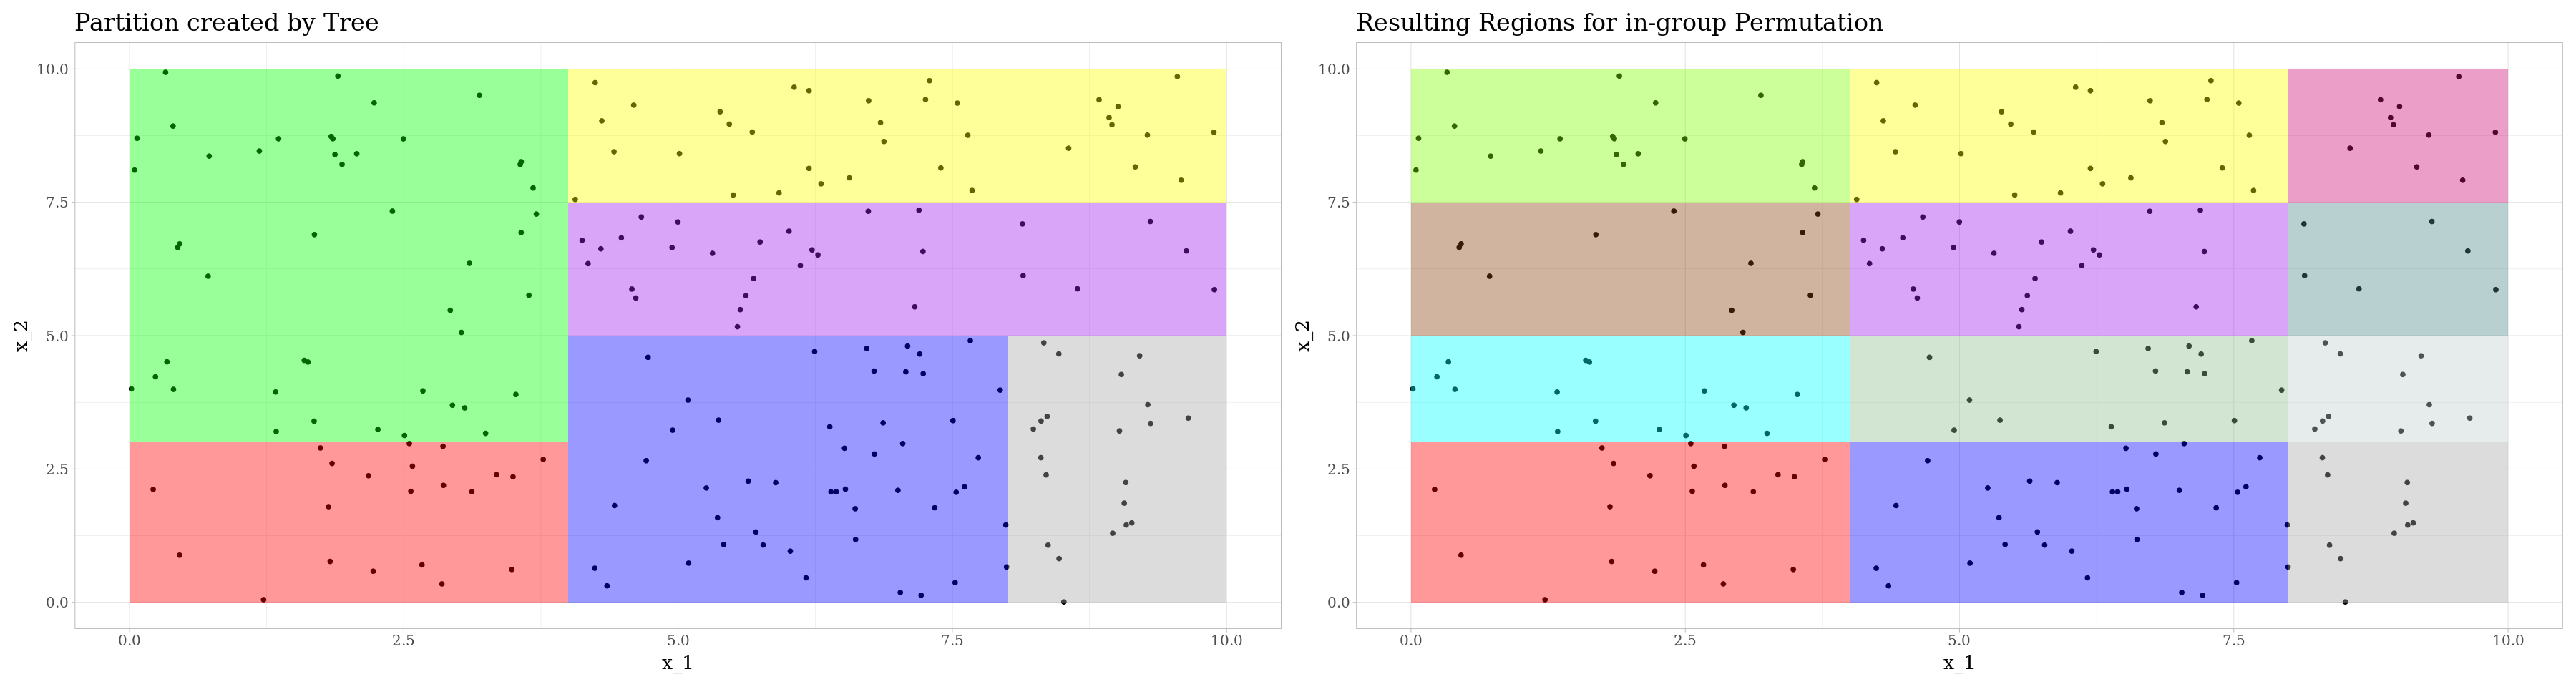

In [40]:
source("Visualizations.R")
CVI_vis()

The permutation scheme relies on extending each split not only to the subtree used for its creation, but to the whole predictor space. This partition of the predictor space is then used to determine which observations form groups in which permutation takes place. The authors argue that this serves to changes the hypothesis implied in the variable importance to

\begin{equation}
H_0: (X_j \perp Y) | Z.
\end{equation}

In a continuous setting where the precise argument is more difficult to make, they argue that this serves as a reasonable approximation as observations with identical realizations of covariates are unlikely but observations in the same region are suitably comparable to apply the procedure nevertheless.

<span style="color:red"> HIER WEITERSCHREIBEN!!! </span>.

### Conditional Inference Trees <a name="CIT"></a>
---
Introduced by *Hothorn, Hornik, and Zeileis (2006)*, Conditional Inference Trees (**CIT**) try to address the problem of selection bias of typical random trees based for example on **CART** decribed in the previous paragraph by modifying the recursive binary partitioning procedure. To do so they devise a method based on a testing framework for permutation tests by *Strasser and Weber (1999)*. The authors describe the algorithm used to construct the tree in the following three steps (quote):
> 1. For case weights $w$ test the global null hypothesis of independence between any of the
$m$ covariates and the response. Stop if this hypothesis cannot be rejected. Otherwise
select the $j^{*}$th covariate $X_{j*}$ with strongest association to $Y$.
> 2. Choose a set $A^{*} \subset \mathcal{X}_{j^{*}}$ in order to split $\mathcal{X}_{j^{*}}$ into two disjoint sets $A^{*}$ and $\mathcal{X}_{j^{*}} \setminus A^{*}$. The case weights $w_{\text{left}}$ and $w_{\text{right}}$ determine the two subgroups with $w_{\text{left}, i} = w_i I(\mathcal{X}_{j^{*} \: i} \in A^{*})$ and $w_{\text{right}, i} = w_i I(\mathcal{X}_{j^{*} \: i} \notin A^{*})$ for all $i = 1, \dots , n$ ($I(\:)$ denotes
the indicator function).
> 3. Recursively repeat Steps 1 and 2 with modified case weights $w_{\text{left}}$ and $w_{\text{right}}$, respectively.

Here the non-negative integer-valued weights $w$ serve as indicators as to which region of predictor space an observation lies in.

Where in **CART** the variable $X_j$ with strongest association to $Y$ would be chosen by comparing the reduction in **RSS**, this method employs a different approach. Given the global hypothesis of independence between $X$ and $Y$ at a node, partial independence hypotheses for each dimension $X_j$ are constructed and tested using a linear hypothesis in the framework of permutation tests. If the global hypothesis cannot be discarded from the teststatistic constructed from the calculations of the partial hypotheses an additional split is performed in the dimension where the test statistic for the partial independence hypothesis is associated with the smallest p-value. Here a multiple testing correction for the partial hypotheses becomes important due to the interaction of testing multiple hypotheses while also wanting to control the family wise error rate (**FWER**). Concerning this correction the authors name a simple bonferroni correction while also referring to more advanced multiple testing literature.<br>

A theoretical presentation of the testing framework is out of the scope of this project, but intuitively this method leads to a stopping criterion based on statistical testing theory and fixed levels of significance and thereby improves interpretability of results (at each split an uninformative variable is chosen with a probability of $\alpha$ or less) and works against overfitting (by introducing an alternative stopping criterion based on the global hypothesis of independence at a node). In simulations performed by the authors this mehod is competitive with optimally pruned trees created by **CART** while also improving on the variable selection biases exhibited by previous methods.

<span style="color:red"> HIER WEITERSCHREIBEN!!! </span>.

### Conditional Inference Random Forests <a name="CIRF"></a>
---
Given that conditional inference trees are only based on a different method to construct a structurally similar tree to **CART** it is not surprising that a random forest can be based on **CIT** as well. This has been done previosly and apart from a considerably higher computational cost from **CART** random forest has shown expected improvements over **CART** random forest in addressing the inherent biases of **CART** towards variables with more categories or continuous scale. However, as previously mentioned simulation studies have shown that constructing a random forest via bootstrapping has its own biases which are not corrected by simply switching the basal tree type of a random forest to **CIT**.

### Permutation Approach by Hapfelmeier and Ulm <a name="hpflmr_ulm"></a>
---
Developed by *Hapfelmeier and Ulm (2013)* there is another permutation importance based approach for feature selection that at the cost of further icreasing computational cost improves on certain properties of previous approaches. Their idea relies on approximating the distribution of an importance measure for each covariate under a specific independence hypothesis using a form of Monte-Carlo simulation and constructing a series of random forests based on permuted data. Using this approximated distribution a testing approach can be used to determine if the realized importance measure derived for a set of random forests based on the unpermuted data indicates a violation of the indipendence hypothesis.

## Implementations <a name="implementation"></a>
---
To understand the simulations conducted in the later parts of this project it is also important to understand what is actually calculated when using the preimplemented functions of the packages. These will mainly include **randomForest**, **party**, and **partykit**.
The relevant citations for these packages are included in the biobliography and can additionally be accessed using the *citation("\<packagename\>")* command. For more detailed information on the packages refer to the manuals provided on **CRAN** by the authors.

### package randomForest <a name="pckg_rf"></a>
---
When using the R package *randomForest* (*Liaw and Wiener (2001)*) as I will be in parts of the simulation studies, up to four importance measures are calculated when applying the function *randomForest*. For their definitions  the authors refer to *Breiman (2002)*. The following excerpts are quoted from the manual:

Measure 1:
> To estimated the importance of the mth variable. In the left out
cases for the kth tree, randomly permute all values of the mth
variable Put these new covariate values down the tree and get
classifications. <br>
> Proceed as though computing a new internal error rate. The amount
by which this new error exceeds the original test set error is defined
as the importance of the mth variable.

Measures 2 and 3:
>For the nth case in the data, its margin at the end of a run is the
proportion of votes for its true class minus the maximum of the
proportion of votes for each of the other classes. The 2nd measure
of importance of the mth variable is the average lowering of the
margin across all cases when the mth variable is randomly permuted
as in method 1. <br>
>
>The third measure is the count of how many margins are lowered
minus the number of margins raised.

Measure 4:
> The splitting criterion used in RF is the gini criterion--also used in
CART. At every split one of the mtry variables is used to form the
split and there is a resulting decrease in the gini. The sum of all
decreases in the forest due to a given variable, normalized by the
number of trees, froms (sic) measure 4.

Measure 1 is the typical case of a permutation based importance measure as previously motivated. 

### package party & partykit <a name="pckg_party"></a>
---


## Functions for Simulation <a name="functions"></a>
---

#### permute_dim

This function takes an index **i** and a data.frame / tibble **df** and randomly permutes the covariate / the dependent variable corresponding to the given index. <br>
As an example **i = 2** corresponds to **X_2**. To permute **Y** set **i = 0**.

In [29]:
# i: index of column to permute, if i == 0 permute Y
# df: data.frame or tibble with data

permute_dim <- function(i = 0, df){
    
    # check if index is out of bounds
    if((i < 0) || (i > dim(df)[2] - 1)){
        stop("'permute_dim' - index error")
    }
    
    n_obs <- dim(df)[1]
    # permute Y if i == 0
    if(i == 0){
        df$Y <- sample(df$Y, size = n_obs, replace = FALSE)
    } 
    # Otherwise permute chosen column of X
    else{
        df[[i+1]] <- sample(df[[i+1]], size = n_obs, replace = FALSE)
    }
    # return permuted objects for further analysis
    return(df)
}

#### parallel_helper
This function acts as a helper to the parallelized procedure. Given an index **i** and a data.frame / tibble **df**, it randomly permutes the entry corresponding to the index and creates a conditional inference random forest using the partially permuted data. <br>
The conditional inference random forest is then returned.

In [24]:
# i: index of column to permute, if i == 0 permute Y
# df: data.frame or tibble with data
# seed: seed for random number generation

parallel_helper <- function(i, df, seed){
    
    #set seed to ensure reproducibility
    set.seed(seed)
    
    # randomly permute chosen entry
    tmp_df <- permute_dim(i, df)
    
    # return conditional inference random forest
    return(cforest(formula = Y ~ ., data = tmp_df))
}

#### parallel_permute_forest
This function acts as a wrapper to **parallel_helper** and performs non-load-balanced cluster parallelization to speed up the process while still ensuring reproducibility. <br>
Its arguments are:
* **cl**: a cluster object generated by the parallel package (for UNIX based systems use Forking Cluster, for Windows switch function calls to PSOCK Cluster and ensure that functions are available in the scope of the respective nodes)
* **i**: index given to **parallel_helper**
* **df**: data.frame / tibble given to **parallel_helper**
* **reps**: number of repetitions for **parallel helper**. If provided together with seeds, ensure that the number of seeds is identical to reps.
* **df**: vector of integers given to **parallel_helper** as seeds in parallelization. If provided together with reps, ensure that the number of seeds is identical to reps.

In [28]:
# cl: cluster object generated by parallel package
# i: index of column to permute, if i == 0 permute Y
# df: data.frame or tibble with data
# reps: number of permutations and corresponding random forests
# seeds: seeds for the permutation (set in parallel_helper)

parallel_permute_forest <- function(cl, i, df, reps = NULL, seeds = NULL){
    
    # Check argument structure
    if(missing(reps) && missing(seeds)){
        stop("'parallel_permute_forest' - Insufficient arguments: one of reps or seeds has to be provided")
    } else if(length(seeds) != reps){
        stop("'parallel_permute_forest' - number of seeds is different from reps")
    } else if(missing(seeds)){
        seeds <- sample(1:10e8, size = reps, replace = FALSE)
    } else if(missing(reps)){
        reps <- length(seeds)
    }
    
    # use non-load-balancing cluster parallelization to speed up the process and ensure reproducibility
    cond_inf_rnd_frsts <- clusterApply(x = seeds,
                                       fun = function(seed) parallel_helper(i = i, df = df, seed = seed))
    
    # return list of conditional inference random forests generated in parallel
    return(cond_inf_rnd_frsts)
}

## Simulation Study <a name="simulation"></a>
---

In [18]:
#Test
n = 100
p = 10

my_mu <- rep(0, times = p)
my_Sigma <- diag(rep(1, times = p))
X <- cbind(rep(1, times = n), mvrnorm(n = n, mu = my_mu, Sigma = my_Sigma))
eps <- rnorm(n = n)

beta <- runif(n = p+1, min = -1, max = 1)
Y = X %*% beta + eps

my_tibble <- cbind(tibble(Y = Y), suppressWarnings(as_tibble(X)))
names(my_tibble) <- c('Y', paste0("X_", as.character(1:p)))

cond_forest <- cforest(formula = Y ~ ., data = my_tibble)
summary(cond_forest)

         Length Class      Mode    
nodes    500    -none-     list    
data      12    data.frame list    
weights  500    -none-     list    
fitted     2    data.frame list    
terms      3    terms      call    
info       2    -none-     list    
trafo      1    -none-     function
predictf   2    terms      call    

## Application <a name="application"></a>
---

## Conclusion <a name="conclusion"></a>
---

## Outlook and Possible Extensions <a name="outlook"></a>
---

## Bibliography <a name="bibliography"></a>
---
* Breiman, Leo. “Random Forests.” Machine Learning 45, no. 1 (October 1, 2001): 5–32. https://doi.org/10.1023/A:1010933404324.
* Breiman, Leo, Jerome Friedman, Charles J. Stone, and R. A. Olshen. Classification and Regression Trees. Taylor & Francis, 1984.
* Hapfelmeier, A., and K. Ulm. “A New Variable Selection Approach Using Random Forests.” Computational Statistics & Data Analysis 60 (April 1, 2013): 50–69. https://doi.org/10.1016/j.csda.2012.09.020.
* Ho, Tin Kam. “Random Decision Forests.” In Proceedings of 3rd International Conference on Document Analysis and Recognition, 1:278–82 vol.1, 1995. https://doi.org/10.1109/ICDAR.1995.598994.
* Hothorn, Torsten, Kurt Hornik, and Achim Zeileis. “Unbiased Recursive Partitioning: A Conditional Inference Framework.” Journal of Computational and Graphical Statistics 15, no. 3 (September 1, 2006): 651–74. https://doi.org/10.1198/106186006X133933.
* Hothorn, Torsten, and Achim Zeileis. “Partykit: A Modular Toolkit for Recursive Partytioning in R.” Journal of Machine Learning Research 16, no. 118 (2015): 3905–9.
* Ishwaran, Hemant. “Variable Importance in Binary Regression Trees and Forests.” Electronic Journal of Statistics 1, no. none (January 2007): 519–37. https://doi.org/10.1214/07-EJS039.
* James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An Introduction to Statistical Learning: With Applications in R. 1st ed. 2013, Corr. 7th printing 2017 edition. New York: Springer, 2013.
* Liaw, Andy, and Matthew Wiener. “Classification and Regression by RandomForest.” Forest 23 (November 30, 2001).
* Strobl, Carolin, Anne-Laure Boulesteix, Thomas Kneib, Thomas Augustin, and Achim Zeileis. “Conditional Variable Importance for Random Forests.” BMC Bioinformatics 9 (August 1, 2008): 307. https://doi.org/10.1186/1471-2105-9-307.
* Strobl, Carolin, Anne-Laure Boulesteix, Achim Zeileis, and Torsten Hothorn. “Bias in Random Forest Variable Importance Measures: Illustrations, Sources and a Solution.” BMC Bioinformatics 8, no. 1 (January 25, 2007): 25. https://doi.org/10.1186/1471-2105-8-25.


* L. Breiman. Manual on setting up, using, and understanding random forests v3.1, 2002. http://oz.berkeley.edu/users/breiman/Using_random_forests_V3.1.pdf